In [7]:
#####
#--- preliminaries ----
#####

library(mvtnorm)
library(MCMCpack)
library(raster)
library(Hmisc)
library(sp)
library(rgdal)
library(RColorBrewer)
library(maptools)

Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


Attaching package: 'maptools'


The following object is masked from 'package:Hmisc':

    label




In [40]:
#####
#--- illustrate and sensitivity test single source implementation ----
#####

#illustrate case
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)
HO_obs = rmvnorm(1000, c(obs$H, obs$O), matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
H_obs = HO_obs[,1]
O_obs = HO_obs[,2]
obs_prob = vector(,ngens)
for(i in 1:ngens){
    obs_prob[i] = dmvnorm(c(H_obs[i], O_obs[i]),c(obs$H, obs$O), sigma=matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
  }

In [ ]:
#hypothesized slope value (slope, sd)
hslope = c(4.5, 0.3)

#get results and report average conditional probability for test case
results = sourceprob(obs, hsource, hslope)

In [8]:
#####functions here

#####
#--- isotope value data frame ----
#creates object of 'iso' data structure used to pass values to functions
#####

#takes values of H and O isotope composition, SD of each, and covariance
iso = function(H,O,Hsd,Osd,HOc){
  return(data.frame(H=H, O=O, Hsd=Hsd, Osd=Osd, HOc=HOc))
}

In [9]:
#####
#--- single source implementation ----
#####

#takes values of observed and hypothesized source water (each type 'iso'), hypothesized EL slope value
#prior probability of source, and number of parameter draws
sourceprob = function(obs, hsource, hslope, prior=1, ngens=10000){
  
  #ngens observed values
  HO_obs = rmvnorm(ngens, c(obs$H, obs$O), matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
  H_obs = HO_obs[,1]
  O_obs = HO_obs[,2]
  obs_prob = vector(,ngens)
  for(i in 1:ngens){
    obs_prob[i] = dmvnorm(c(H_obs[i], O_obs[i]),c(obs$H, obs$O), sigma=matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
  }
  
  #ngens hypothesized source values
  HO_h = rmvnorm(ngens, c(hsource$H, hsource$O), matrix(c(hsource$Hsd^2, rep(hsource$HOc*hsource$Hsd*hsource$Osd,2), hsource$Osd^2),2,2))
  H_h=HO_h[,1]
  O_h=HO_h[,2]
  hypo_prob = vector(,ngens)
  for(i in 1:ngens){
    hypo_prob[i] = dmvnorm(c(H_h[i], O_h[i]),c(hsource$H, hsource$O), sigma=matrix(c(hsource$Hsd^2, rep(hsource$HOc*hsource$Hsd*hsource$Osd,2), hsource$Osd^2),2,2))
  }
  
  #get slope and standardized source probability for each case
  S = (H_obs-H_h)/(O_obs-O_h)
  Sprob = dnorm(S, hslope[1], hslope[2])/dnorm(hslope[1], hslope[1], hslope[2])
  
  #if sample value lies below or left of source evaporation can't explain it
  msk = ifelse(H_h > H_obs | O_h > O_obs, 0, 1)
  Sprob = Sprob * msk
  goods = sum(msk)

  results = data.frame(H_h, O_h, hypo_prob, H_obs, O_obs, obs_prob, Sprob) #return data frame w/ all draws

  print(paste(goods, "out of", ngens))  #how many non-zero probabilities?

  return(results)
  
}

In [50]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)
mwl=c(8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672)
hslope = c(4.5, 0.3)

#run the test case
results = mwlsource(obs, c(8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672), hslope)

In [10]:
#####
#--- MWL source implementation ----
#####

#takes values of observed water (type 'iso'), MWL (see below), hypothesized EL slope value
#and number of parameter draws
mwlsource = function(obs, mwl=c(8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672), hslope, ngens=10000){
  #mwl contains parameters for the meteoric water line:
  #slope, intercept, sum of squares in d2H, sum of squares in d18O, average d18O, and number of samples.
  #Defaults were calculated from precipitation samples extracted from waterisotopes.org DB on 7/7/2017,
  #screened to include only samples with -10 < Dex < 30 

  #establish credible range for source water d18O
  o_cent = (mwl[2]-(obs$H - hslope[1]*obs$O) ) / (hslope[1]-mwl[1])
  o_min = o_cent-10
  o_max = o_cent+5
  sr = sqrt((mwl[3] - (mwl[1]^2 * mwl[4]))/(mwl[6]-2))  ##sum of squares

  #space for results
  results = data.frame("H_h"=double(), "O_h"=double(), "hypo_prob"=double(), "H_obs"=double(), "O_obs"=double(), "obs_prob"=double(), "Sprob"=double())
  i=1
  
  #iterate until ngens draws in posterior
  while(i<=ngens){
    
    #observed H and O values from bivariate normal
    HO_obs = rmvnorm(1, c(obs$H, obs$O), matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
    
    #hypothesized source O from uniform spanning interval obtained above
    O_h = o_min + runif(1) * (o_max - o_min)
    
    #use st err of prediction to draw hypothesized source H from normal distribution around MWL
    sy = sr * sqrt(1 + 1 / mwl[6] + (O_h - mwl[5])^2 / mwl[4])  ##prediction standard error, e.g., http://science.widener.edu/svb/stats/regress.html and http://www.real-statistics.com/regression/confidence-and-prediction-intervals/
    H_h = rnorm(1, O_h * mwl[1] + mwl[2], sy)

    #get slope for draw and standardized probability    
    S = (HO_obs[1]-H_h)/(HO_obs[2]-O_h)
    Sprob = dnorm(S, hslope[1], hslope[2])/dnorm(hslope[1], hslope[1], hslope[2])
    Sprob = ifelse(H_h > HO_obs[1] | O_h > HO_obs[2], 0, Sprob)

    #keep it or discard    
    if(runif(1)<Sprob){
      hypo_prob = dnorm(H_h, O_h * mwl[1] + mwl[2], sy)
      obs_prob = dmvnorm(c(HO_obs[1], HO_obs[2]),c(obs$H, obs$O), sigma=matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
      results = rbind(results, c(H_h, O_h, hypo_prob, HO_obs[1], HO_obs[2], obs_prob, Sprob, 0))
      i=i+1
    }
  }

  #reassign names to results dataframe
  results@names = c("H_h", "O_h", "hypo_prob", "H_obs", "O_obs", "obs_prob", "Sprob")

  return(results)
  
}


In [11]:
#####
#--- Mixtures implementation ----
#####

#takes values of observed and hypothesized endmember source waters (each type 'iso'),hypothesized EL slope,
#prior (as relative contribution of each source to mixture), and number of parameter draws
mixprob = function(obs, hsource, hslope, prior=rep(1,nrow(hsource)), shp=2, ngens=10000){

  #get number of sources
  nsource = nrow(hsource)

  #set up spaces and indicies
  i=1; iter=1
  HO_hypo = matrix(, nsource, 2)
  H_obs = vector(,ngens)
  O_obs = vector(,ngens)
  H_h = vector(,ngens)
  O_h = vector(,ngens)
  fracs = matrix(,ngens,nsource)
  obs_prob = vector(,ngens)
  hypo_prob = vector(,ngens)
  fracs_prob = vector(,ngens)
  Sprob = vector(,ngens)
  prob_hold = vector(,nsource)

  #iterate until ngens draws in posterior
  while(i<=ngens){
    #observed values; note that DoParllel needs namespace for mvtnorm functions
    HO_obs = mvtnorm::rmvnorm(1, c(obs$H, obs$O), matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
    H_obs[i] = HO_obs[1]
    O_obs[i] = HO_obs[2]
    
    #hypothesized values
    for(j in 1:nsource){
      HO_hypo[j,] = mvtnorm::rmvnorm(1, c(hsource$H[j], hsource$O[j]), matrix(c(hsource$Hsd[j]^2, rep(hsource$HOc[j]*hsource$Hsd[j]*hsource$Osd[j],2), hsource$Osd[j]^2),2,2))
    }
    
    #mixture
    alphas = prior/min(prior) * shp
    fracs[i,] = MCMCpack::rdirichlet(1, alphas)
    H_h[i] = sum(HO_hypo[,1] * fracs[i,])
    O_h[i] = sum(HO_hypo[,2] * fracs[i,])
    
    #evaluate conditional probability
    if(H_h > H_obs || O_h > O_obs){
      Sprob[i] = 0
    } else{
      S = (H_obs[i]-H_h[i])/(O_obs[i]-O_h[i])
      Sprob[i] = dnorm(S, hslope[1], hslope[2])/dnorm(hslope[1], hslope[1], hslope[2])
    }
    
    #check whether to retain
    if(runif(1) < Sprob[i]){
      obs_prob[i] = mvtnorm::dmvnorm(HO_obs, sigma=matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
      fracs_prob[i] = MCMCpack::ddirichlet(fracs[i,], alphas)
      for(j in 1:nsource){
        prob_hold[j] = mvtnorm::dmvnorm(HO_hypo[j,], c(hsource$H[j], hsource$O[j]), matrix(c(hsource$Hsd[j]^2, rep(hsource$HOc[j]*hsource$Hsd[j]*hsource$Osd[j],2), hsource$Osd[j]^2),2,2))
      }
      hypo_prob[i] = prod(prob_hold)
      i = i + 1
    }
    
    #check for poorly posed
    iter = iter + 1
    if(iter > 10000 && i/iter <  0.01){
      warning("too few valid draws")
      break()
    }
  }
  
  #bundle results in data frame
  results = data.frame(H_h, O_h, hypo_prob, H_obs, O_obs, obs_prob, fracs, fracs_prob, Sprob)

  #report on efficiency
  print(paste(iter, "iterations for", ngens, "posterior samples"))
  
  return(results)
  
}

In [62]:



#parameter values
nits = 10 #num evap samples
s = 4.5 #EL slope
ssd = 0.5 #slope SD

#prescribed X/Y for sources
swo = c(-10.2, -8.5, -5.7, -6.8)
swh = swo * 8 + 10 + rnorm(4)

#space for samples
ewo = matrix(nrow = nits, ncol = 4)
ewh = matrix(nrow = nits, ncol = 4)

#generate samples for random model
for(i in 1:4){
  enro = runif(nits) * 5
  ewo[, i] = swo[i] + enro
  ewh[, i] = swh[i] + enro * (4.5 + rnorm(nits)*ssd)
}

#generate samples for correlated model
mths = 12
enoise = 1
seas = (sin(2*pi*seq(1,mths)/mths))
seaso = mean(swo) + (max(swo) - min(swo)/1.5) * seas
seash = seaso * 8 + 10 + rnorm(mths)
enro = (seas + 1.5) * 2.5 + rnorm(mths) * enoise
seaseo = seaso + enro
seaseh = seash + enro * (4.5 + rnorm(mths)*ssd)

In [64]:
#plotting - make space
setEPS()
postscript("Figure1.eps", width = 12.6/2.54, height = 4.8/2.54)
#jpeg("Figure1.jpg", units = "cm", res = 600, width = 15, height = 5)
layout(matrix(c(1,2,3), 1, 3), widths=c(lcm(4.86), lcm(3.86), lcm(3.86)))

#panel 1 shows theory
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)
plot(-5,-5, type="n", xlim = c(-12,0), ylim = c(-80,0), xlab = expression(paste(delta^{18}, "O (\u2030)")), ylab = expression(paste(delta^{2}, "H (\u2030)")))
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
abline(10, 8, xlim = c(-12,0), ylim = c(-80,0))
abline(10-8*3.5, 4.5, col="red")
points(-8, -54, pch=16, col="red")
points(-3, -54+5*4.5, pch=21, col="red", bg="white")
text(-4, -13, pos = 4, "LMWL", srt = 50)
text(-2, -29, pos = 4, "EL", srt = 33)
text(-11.7, -2, "a")
lines(c(-7.5, -3.5), c(-55, -37))
lines(c(-3.5, -3.7), c(-37, -39))
lines(c(-3.5, -3.86), c(-37, -37.5))
text(-5.3, -49, "evapoconcentration", srt=33, cex=0.8)
box()

#panel 2 shows correct interpretation
par(mai=c(0.5,0.1,0.1,0.1), cex=0.5)
plot(swo, swh, type = "n", xlim = c(-12,0), ylim = c(-80, 0), axes=FALSE, xlab = expression(paste(delta^{18}, "O (\u2030)")), ylab="")
axis(1)
axis(2, labels=FALSE)
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
abline(10, 8)
abline(lm(ewh[,1]~ewo[,1]), col="blue")
abline(lm(ewh[,2]~ewo[,2]), col="green")
abline(lm(ewh[,3]~ewo[,3]), col="red")
abline(lm(ewh[,4]~ewo[,4]), col="orange")
points(ewo[,1], ewh[,1], col="blue", pch=21, bg="white")
points(ewo[,2], ewh[,2], col="green", pch=21, bg="white")
points(ewo[,3], ewh[,3], col="red", pch=21, bg="white")
points(ewo[,4], ewh[,4], col="orange", pch=21, bg="white")
points(swo, swh, col=c("blue", "green", "red", "orange"), pch=16)
text(-11.7, -2, "b")
box()

#panel 3 shows naieve interpretation
plot(swo, swh, type = "n", xlim = c(-12,0), axes=FALSE, ylim = c(-80, 0), xlab = expression(paste(delta^{18}, "O (\u2030)")), ylab="")
axis(1)
axis(2, labels=FALSE)
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
abline(10, 8)
abline(lm(seaseh~seaseo))
points(seaseo, seaseh, xlim = c(-12,0), ylim = c(-80, 0), pch=21, bg="white")
points(swo, swh, col=c("blue", "green", "red", "orange"), pch=16)
points(mean(seaso), mean(seash), pch=16)
text(-11.7, -2, "c")
box()



In [ ]:
dev.off()

[1] "10000 out of 10000"


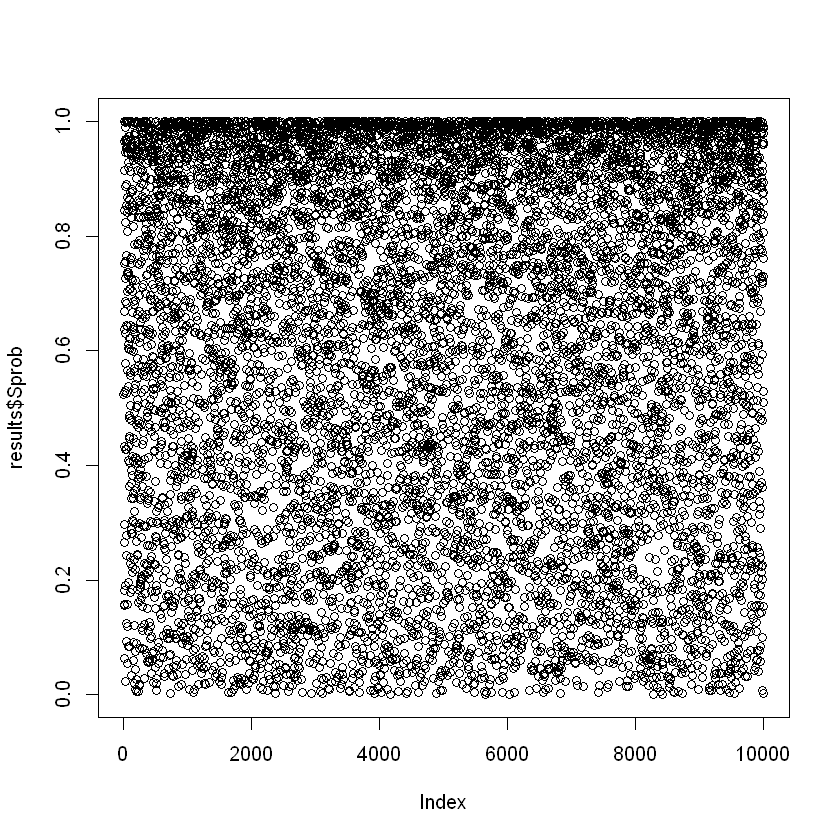

In [65]:
#####
#--- illustrate and sensitivity test single source implementation ----
#####

#illustrate case
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = c(4.5, 0.3)

#get results and report average conditional probability for test case
results = sourceprob(obs, hsource, hslope)
cond = sum(results$Sprob)/nrow(results)

plot(results$Sprob)

In [17]:
#Plot first panel
#only show first 250 draws
nex = 250   

#set up space for figure 2
#jpeg("Figure2.jpg", units = "cm", res = 600, width = 15, height = 7)
setEPS()
postscript("Figure2.eps", width=12.6/2.54, height = 6.2/2.54)
layout(matrix(c(1,2), 1, 2), widths=c(lcm(6.8), lcm(5.8)))

#first panel
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)
lim = c(min(results$O_h, results$O_obs)-0.5, max(results$O_h, results$O_obs)+0.5, min(results$H_h, results$H_obs)-4, max(results$H_h, results$H_obs)+4)
plot(results$O_h[1],results$H_h[1],xlim=c(lim[1], lim[2]), ylim=c(lim[3], lim[4]), axes=FALSE,
     xlab=expression(paste(delta^{18}, "O (\u2030)")),
     ylab=expression(paste(delta^{2}, "H (\u2030)")))
axis(1)
axis(2)
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
abline(10, 8, lw=1)

lcols = ( 0.9 - 0.9*(results$hypo_prob[1:nex])/max(results$hypo_prob[1:nex]))
lcols = mapply(max, lcols, 0)
S=(results$H_obs - results$H_h) / (results$O_obs - results$O_h)
mapply(abline, a=results$H_obs[1:nex] - S[1:nex] * results$O_obs[1:nex], b=S[1:nex], col=rgb(1, lcols, lcols, max=1))

points(results$O_h[1:nex],results$H_h[1:nex], pch=21, col=rgb(lcols, lcols, lcols, max=1), bg="white")
points(results$O_obs[1:nex], results$H_obs[1:nex], pch=21, col=rgb(1, lcols, lcols, max=1), bg="white")
abline(obs$H - obs$O * hslope[1], hslope[1])
points(hsource$O, hsource$H, pch=21, bg="black")
points(obs$O, obs$H, pch=21, col="red", bg="black")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], border = "black")
text(par("usr")[1] + (par("usr")[2]-par("usr")[1]) * 0.05,  par("usr")[4] - (par("usr")[4]-par("usr")[3]) * 0.05, "a")
box()

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
NULL

[[103]]
NULL

[[104]]
NULL

[[105]]
NULL

[[106]]
NULL

[[107]]
NULL

[[108]]
NULL

[[109]]
NULL

[[110]]
NULL

[[111]]
NULL

[[112]]
NULL

[[113]]
NULL

[[114]]
NULL

[[115]]
NULL

[[116]]
NULL

[[117]]
NULL

[[118]]
NULL

[[119]]
NULL

[[120]]
NULL

[[121]]
NULL

[[122]]
NULL

[[123]]
NULL

[[124]]
NULL

[[125]]
NULL

[[126]]
NULL

[[127]]
NULL

[[128]]
NULL

[[129]]
NULL

[[130]]
NULL

[[131]]
NULL

[[132]]
NULL

[[133]]
NULL

[[134]]
NULL

[[135]]
NULL

[[136]]
NULL

[[137]]
NULL

[[138]]
NULL

[[139]]
NULL

[[140]]
NULL

[[141]]
NULL

[[142]]
NULL

[[143]]
NULL

[[144]]
NULL

[[145]]
NULL

[[146]]
NULL

[[147]]
NULL

[[148]]
NULL

[[149]]
NULL

[[150]]
NULL

[[151]]
NULL

[[152]]
NULL

[[153]]
NULL

[[154]]
NULL

[[155]]
NULL

[[156]]
NULL

[[157]]
NULL

[[158]]
NULL

[[159]]
NULL

[[160]]
NULL

[[161]]
NULL

[[162]]
NULL

[[163]]
NULL

[[164]]
NULL

[[165]]
NULL

[[166]]
NULL

[[167]]
NULL

[[168]]
NULL

[[169]]
NULL

[[170]]
NULL

[[171]]
NULL

[[172]]
NULL

[[173]]
NULL

[[174]]
NULL

[[175]]
NULL

[[176]]
NULL

[[177]]
NULL

[[178]]
NULL

[[179]]
NULL

[[180]]
NULL

[[181]]
NULL

[[182]]
NULL

[[183]]
NULL

[[184]]
NULL

[[185]]
NULL

[[186]]
NULL

[[187]]
NULL

[[188]]
NULL

[[189]]
NULL

[[190]]
NULL

[[191]]
NULL

[[192]]
NULL

[[193]]
NULL

[[194]]
NULL

[[195]]
NULL

[[196]]
NULL

[[197]]
NULL

[[198]]
NULL

[[199]]
NULL

[[200]]
NULL

[[201]]
NULL

[[202]]
NULL

[[203]]
NULL

[[204]]
NULL

[[205]]
NULL

[[206]]
NULL

[[207]]
NULL

[[208]]
NULL

[[209]]
NULL

[[210]]
NULL

[[211]]
NULL

[[212]]
NULL

[[213]]
NULL

[[214]]
NULL

[[215]]
NULL

[[216]]
NULL

[[217]]
NULL

[[218]]
NULL

[[219]]
NULL

[[220]]
NULL

[[221]]
NULL

[[222]]
NULL

[[223]]
NULL

[[224]]
NULL

[[225]]
NULL

[[226]]
NULL

[[227]]
NULL

[[228]]
NULL

[[229]]
NULL

[[230]]
NULL

[[231]]
NULL

[[232]]
NULL

[[233]]
NULL

[[234]]
NULL

[[235]]
NULL

[[236]]
NULL

[[237]]
NULL

[[238]]
NULL

[[239]]
NULL

[[240]]
NULL

[[241]]
NULL

[[242]]
NULL

[[243]]
NULL

[[244]]
NULL

[[245]]
NULL

[[246]]
NULL

[[247]]
NULL

[[248]]
NULL

[[249]]
NULL

[[250]]
NULL

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
NULL

[[103]]
NULL

[[104]]
NULL

[[105]]
NULL

[[106]]
NULL

[[107]]
NULL

[[108]]
NULL

[[109]]
NULL

[[110]]
NULL

[[111]]
NULL

[[112]]
NULL

[[113]]
NULL

[[114]]
NULL

[[115]]
NULL

[[116]]
NULL

[[117]]
NULL

[[118]]
NULL

[[119]]
NULL

[[120]]
NULL

[[121]]
NULL

[[122]]
NULL

[[123]]
NULL

[[124]]
NULL

[[125]]
NULL

[[126]]
NULL

[[127]]
NULL

[[128]]
NULL

[[129]]
NULL

[[130]]
NULL

[[131]]
NULL

[[132]]
NULL

[[133]]
NULL

[[134]]
NULL

[[135]]
NULL

[[136]]
NULL

[[137]]
NULL

[[138]]
NULL

[[139]]
NULL

[[140]]
NULL

[[141]]
NULL

[[142]]
NULL

[[143]]
NULL

[[144]]
NULL

[[145]]
NULL

[[146]]
NULL

[[147]]
NULL

[[148]]
NULL

[[149]]
NULL

[[150]]
NULL

[[151]]
NULL

[[152]]
NULL

[[153]]
NULL

[[154]]
NULL

[[155]]
NULL

[[156]]
NULL

[[157]]
NULL

[[158]]
NULL

[[159]]
NULL

[[160]]
NULL

[[161]]
NULL

[[162]]
NULL

[[163]]
NULL

[[164]]
NULL

[[165]]
NULL

[[166]]
NULL

[[167]]
NULL

[[168]]
NULL

[[169]]
NULL

[[170]]
NULL

[[171]]
NULL

[[172]]
NULL

[[173]]
NULL

[[174]]
NULL

[[175]]
NULL

[[176]]
NULL

[[177]]
NULL

[[178]]
NULL

[[179]]
NULL

[[180]]
NULL

[[181]]
NULL

[[182]]
NULL

[[183]]
NULL

[[184]]
NULL

[[185]]
NULL

[[186]]
NULL

[[187]]
NULL

[[188]]
NULL

[[189]]
NULL

[[190]]
NULL

[[191]]
NULL

[[192]]
NULL

[[193]]
NULL

[[194]]
NULL

[[195]]
NULL

[[196]]
NULL

[[197]]
NULL

[[198]]
NULL

[[199]]
NULL

[[200]]
NULL

[[201]]
NULL

[[202]]
NULL

[[203]]
NULL

[[204]]
NULL

[[205]]
NULL

[[206]]
NULL

[[207]]
NULL

[[208]]
NULL

[[209]]
NULL

[[210]]
NULL

[[211]]
NULL

[[212]]
NULL

[[213]]
NULL

[[214]]
NULL

[[215]]
NULL

[[216]]
NULL

[[217]]
NULL

[[218]]
NULL

[[219]]
NULL

[[220]]
NULL

[[221]]
NULL

[[222]]
NULL

[[223]]
NULL

[[224]]
NULL

[[225]]
NULL

[[226]]
NULL

[[227]]
NULL

[[228]]
NULL

[[229]]
NULL

[[230]]
NULL

[[231]]
NULL

[[232]]
NULL

[[233]]
NULL

[[234]]
NULL

[[235]]
NULL

[[236]]
NULL

[[237]]
NULL

[[238]]
NULL

[[239]]
NULL

[[240]]
NULL

[[241]]
NULL

[[242]]
NULL

[[243]]
NULL

[[244]]
NULL

[[245]]
NULL

[[246]]
NULL

[[247]]
NULL

[[248]]
NULL

[[249]]
NULL

[[250]]
NULL

postscript 
         3

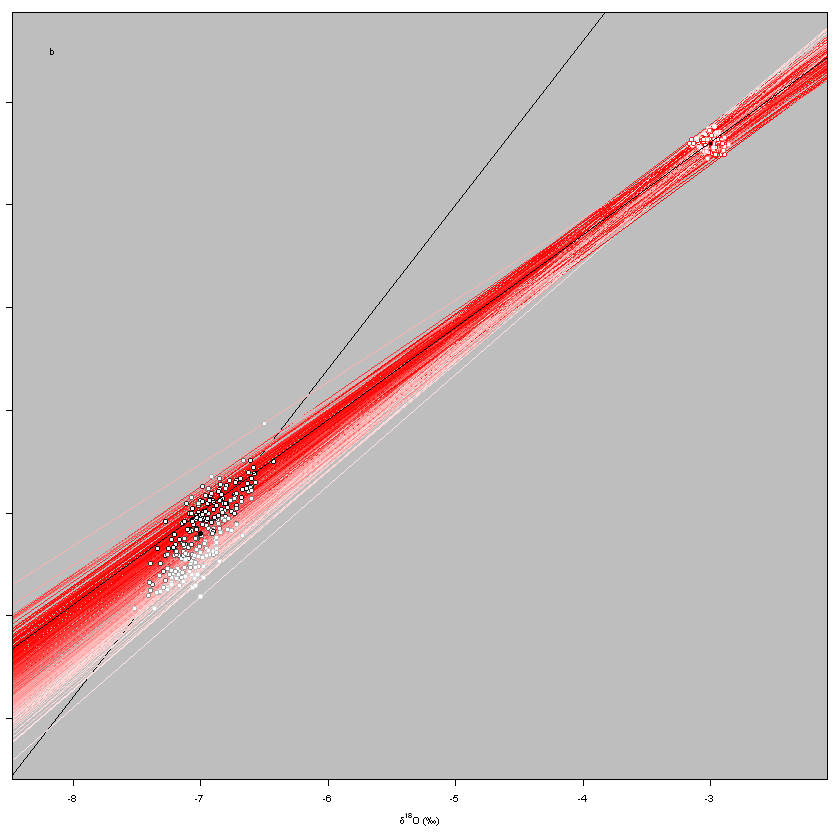

In [18]:
#second panel
par(mai=c(0.5,0.1,0.1,0.1), cex=0.5)
lim = c(min(results$O_h, results$O_obs)-0.5, max(results$O_h, results$O_obs)+0.5, min(results$H_h, results$H_obs)-4, max(results$H_h, results$H_obs)+4)
plot(results$O_h[1],results$H_h[1],xlim=c(lim[1], lim[2]), ylim=c(lim[3], lim[4]), axes=FALSE,
     xlab=expression(paste(delta^{18}, "O (\u2030)")),
     ylab="")
axis(1)
axis(2, labels=FALSE)
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
abline(10, 8, lw=1)

lcols = ( 0.9 - 0.9*(results$Sprob[1:nex])/max(results$Sprob[1:nex]))
lcols = mapply(max, lcols, 0)
S=(results$H_obs - results$H_h) / (results$O_obs - results$O_h)
mapply(abline, a=results$H_obs[1:nex] - S[1:nex] * results$O_obs[1:nex], b=S[1:nex], col=rgb(1, lcols, lcols, max=1))

points(results$O_h[1:nex],results$H_h[1:nex], pch=21, col=rgb(lcols, lcols, lcols, max=1), bg="white")
points(results$O_obs[1:nex], results$H_obs[1:nex], pch=21, col=rgb(1, lcols, lcols, max=1), bg="white")
abline(obs$H - obs$O * hslope[1], hslope[1])
points(hsource$O, hsource$H, pch=21, bg="black")
points(obs$O, obs$H, pch=21, col="red", bg="black")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], border = "black")
text(par("usr")[1] + (par("usr")[2]-par("usr")[1]) * 0.05,  par("usr")[4] - (par("usr")[4]-par("usr")[3]) * 0.05, "b")
box()

dev.off()

In [21]:
#set up space for figure 3
#jpeg("Figure3.jpg", units = "cm", res = 600, width = 7.5, height = 8)
setEPS()
postscript("Figure3.eps", width=8.4/2.54, height=8.4/2.54)
layout(matrix(c(1,2), 2, 1), heights=c(lcm(3.7), lcm(4.7)))

#Panel 1 - sensitivity test slope parameter
par(mai=c(0.1,0.5,0.1,0.1), cex=0.5)
niter  = 50
hsource_o = seq(-9, -5, 4/(niter-1))
ppost = vector(,niter)

#case for precisely known EL slope
hslope = c(4.5, 0.1)   
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 1.6, 0.2, 0.8)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
plot(hsource_o, ppost, type="l", axes=FALSE, xlab="", 
     ylab=("Relative conditional probability"), ylim=c(0,1))
axis(1, labels=FALSE)
axis(2)
text(-7.5, 0.4, "this is extra text to help with orientation")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
lines(hsource_o, ppost, col="blue")

#default case
hslope = c(4.5, 0.3)
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 1.6, 0.2, 0.8)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
lines(hsource_o, ppost, col="black")

#poorly known slope case
hslope = c(4.5, 0.6)
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 1.6, 0.2, 0.8)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
lines(hsource_o, ppost, col="red")
text(par("usr")[1] + (par("usr")[2]-par("usr")[1]) * 0.05,  par("usr")[4] - (par("usr")[4]-par("usr")[3]) * 0.1, "a")
box()

hslope = c(4.5, 0.3)  #reset slope parameters

[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"


[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"
[1] "10000 out of 10000"


postscript 
         3

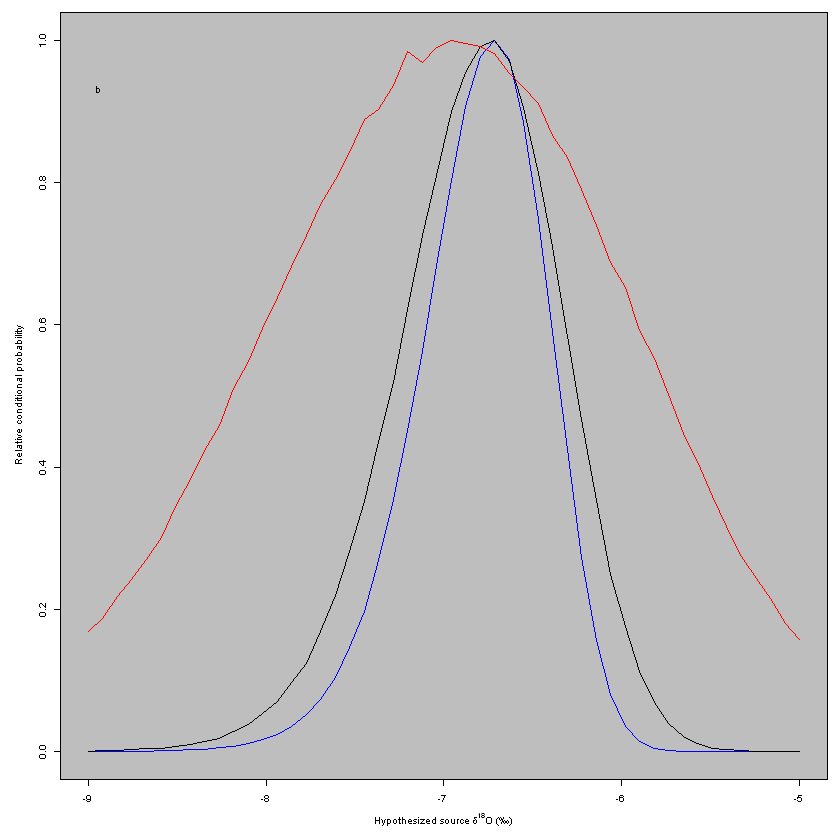

In [22]:
#Panel 2 - sensitivity test source uncertainty
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)
hsource_o = seq(-9, -5, 4/(niter-1))
ppost = vector(,niter)

#precisely known (e.g. measured) source
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 0.25, 0.05, 0)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
plot(hsource_o, ppost, type="l", xlab=expression(paste("Hypothesized source ", delta^{18}, "O (\u2030)")), ylab=("Relative conditional probability"), ylim=c(0,1))
text(-7.5, 0.4, "this is extra text to help with orientation")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
lines(hsource_o, ppost, col="blue")

#default case
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 1.6, 0.2, 0.8)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
lines(hsource_o, ppost, col="black")

#poorly known (e.g. modeled) source
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 5, 0.5, 0.8)  
  results = sourceprob(obs, hsource, hslope, ngens=25000)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
lines(hsource_o, ppost, col="red")
text(par("usr")[1] + (par("usr")[2]-par("usr")[1]) * 0.05,  par("usr")[4] - (par("usr")[4]-par("usr")[3]) * 0.1, "b")

dev.off()

In [23]:
#####
#--- illustrate MWL source implementation ----
#####

#sample values
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = c(4.5, 0.3)

#demonstrate the prior distribution of sources
#ngens observed values
library(mvtnorm)
library(MASS)
ngens=5000
mwl=c(8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672)
HO_obs = rmvnorm(ngens, c(obs$H, obs$O), matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
H_obs = HO_obs[,1]
O_obs = HO_obs[,2]
obs_prob = vector(,ngens)
for(i in 1:ngens){  #bivariate normal probability density for each obs draw
  obs_prob[i] = dmvnorm(c(H_obs[i], O_obs[i]),c(obs$H, obs$O), sigma=matrix(c(obs$Hsd^2, rep(obs$HOc*obs$Hsd*obs$Osd,2), obs$Osd^2),2,2))
}

#ngens d18O from uniform distribution
o_min = -17
o_max = -2
O_h = o_min + runif(ngens) * (o_max - o_min)

#draw d2H using mwl variance
sr = sqrt((mwl[3] - (mwl[1]^2 * mwl[4]))/(mwl[6]-2))  ##sum of squares
sy = sr * sqrt(1 + 1 / mwl[6] + (O_h - mwl[5])^2 / mwl[4])  ##prediction standard error, e.g., http://science.widener.edu/svb/stats/regress.html and http://www.real-statistics.com/regression/confidence-and-prediction-intervals/
H_h = rnorm(ngens, O_h * mwl[1] + mwl[2], sy)
hypo_prob = dnorm(H_h, O_h * mwl[1] + mwl[2], sy)   #normal probability density for each hypo draw

results = data.frame(H_h, O_h, hypo_prob, H_obs, O_obs, obs_prob)


In [24]:
#set up plot space
#jpeg("C:/Users/gjbowen/Dropbox/HypoMirror/WaterOrigin/Figure4.jpg", units = "cm", res = 600, width = 7, height = 7)
setEPS()
postscript("Figure4.eps", width=8.4/2.54, height=8.4/2.54)
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)

#plot prior
nex = ngens
plot(results$O_h[1:nex], results$H_h[1:nex], xlab=expression(paste(delta^{18}, "O (\u2030)")), ylab=expression(paste(delta^{2}, "H (\u2030)")))
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey", border = "black")
results = results[with(results, order(hypo_prob*obs_prob)), ]
lcols = ( 0.9 - 0.9*(results$obs_prob[1:nex] * results$hypo_prob[1:nex])/max(results$obs_prob[1:nex] * results$hypo_prob[1:nex]))
lcols = mapply(max, lcols, 0)
abline(9.57, 8.01)
points(results$O_h[1:nex],results$H_h[1:nex], pch=21, col=rgb(lcols, lcols, lcols, max=1), bg="white")

#run the test case
results = mwlsource(obs, c(8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672), hslope)

#some summary information
dens = kde2d(results$O_h, results$H_h, n=250)
mean(results$H_h)
mean(results$O_h)
quantile(results$H_h, c(0.05, 0.1, 0.5, 0.9, 0.95))
quantile(results$O_h, c(0.05, 0.1, 0.5, 0.9, 0.95))

#poor man's credible regions - show areas in H/O space containning highest X% of densities
dz = as.vector(dens$z)   #extract densities to vector
dzf = data.frame("indx"=seq(1:length(dz)), "val"=dz, "sm"=rep(0), "quant"=rep(0))  #bundle w/ other useful stuff
dzf = dzf[order(-dzf$val),]  #sort by gridcell density
rs=0
for(i in 1:nrow(dzf)){   #accumulate density
  rs = rs + dzf$val[i]
  dzf$sm[i] = rs
}
dzf$quant = ifelse(dzf$sm < 0.95*rs, 0.95, dzf$quant)   #classify using cum dens thresholds
dzf$quant = ifelse(dzf$sm < 0.90*rs, 0.90, dzf$quant)
dzf = dzf[order(dzf$indx),]   #reorder to original 
densq = dens
densq$z = matrix(dzf$quant, 250, 250)   #pop back into original structure

#overlay posterior
points(results$O_h[1:nex],results$H_h[1:nex], pch=21, bg="white", col="blue")
points(obs$O, obs$H, pch=21, col="red", bg="black")    
points(quantile(results$O_h, 0.5), quantile(results$H_h, 0.5), pch=21, col="red", bg="red")   
xlim=c(par("usr")[1], par("usr")[2])
ylim=c(par("usr")[3], par("usr")[4])
contour(densq,  xlab="", ylab="", drawlabels=FALSE, levels=c(0.9, 0.95), col="red", add=TRUE)

dev.off()


[1] -47.24142

[1] -7.415932

5%       10%       50%       90%       95% 
-60.75395 -57.49577 -46.59273 -37.86794 -35.80462

5%        10%        50%        90%        95% 
-10.101877  -9.504294  -7.329690  -5.444082  -4.978338

png 
  2

In [52]:
#####
#--- illustrate mixtures implementation ----
#####

#observed value (H, O, Hsd, Osd, HOcorrelation)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized source values (data frame; H, O, Hsd, Osd, HOcorrelation)
O = c(-9, -3)
H = O*8 + 10
Hsd = rep(1.6,length(H))
Osd = rep(0.2,length(H))
HOc = rep(0.8,length(H))
hsource = iso(H,O,Hsd,Osd,HOc)

#hypothesized slope value (slope, sd)
hslope = c(4.5,0.3)

#case with generic prior
results = mixprob(obs, hsource, hslope, prior=c(2,2))

#simulate prior for plotting
library(MCMCpack)
prior = rdirichlet(10000, c(2,2))

#now plot densities
#jpeg("C:/Users/gjbowen/Dropbox/HypoMirror/WaterOrigin/Figure5.jpg", units = "cm", res = 600, width = 7, height = 6)
setEPS()
postscript("Figure5.eps", width=8.4/2.54, height=7.5/2.54)
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)
plot(density(results$X1, from=0, to=1), main="", ylim=c(0,6), xlab="Source 1 fraction", type="n")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey", border = "black")
lines(density(prior[,1], from=0, to=1), col="white", lty=2)
lines(density(results$X1, from=0, to=1), col="black", lty=2)

#case with informative prior
results = mixprob(obs, hsource, hslope, prior=c(4,2))

#simulate prior for plotting
prior = rdirichlet(10000, c(4,2))

#now plot densities
lines(density(prior[,1], from=0, to=1), col="white")
lines(density(results$X1, from=0, to=1), col="black")

dev.off()


[1] "53795 iterations for 10000 posterior samples"
[1] "40700 iterations for 10000 posterior samples"


png 
  2

In [ ]:
#####
#--- read, prep, and plot data for example analyses ----
#####

#read in EPA waters data
epa_data = read.csv("gis/lakes_w_extract.csv")
nrow(epa_data)
epa_data = subset(epa_data, !is.na(epa_data$h_ann))
epa_data = subset(epa_data, !is.na(epa_data$h_win))
epa_data = subset(epa_data, !is.na(epa_data$h_sum))
nrow(epa_data)

#plotting EPA waters data
#set up
#jpeg("C:/Users/gjbowen/Dropbox/HypoMirror/WaterOrigin/Figure6.jpg", units = "cm", res = 600, width = 7, height = 7)
setEPS()
postscript("Figure6.eps", width=8.4/2.54, height=8.4/2.54)
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)

#plot it
plot(epa_data$d18O, epa_data$d2H, xlim=c(min(epa_data$o_win),max(epa_data$d18O)),
     ylim=c(min(epa_data$h_win),max(epa_data$d2H)), 
     xlab=expression(paste(delta^{18}, "O (\u2030)")),
     ylab=expression(paste(delta^{2}, "H (\u2030)")), type="n")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey", border = "black")
points(epa_data$d18O, epa_data$d2H, pch=19, cex=0.35)
abline(10, 8)
points(epa_data$o_sum, epa_data$h_sum, pch=19, cex=0.35, col="red")
points(epa_data$o_win, epa_data$h_win, pch=19, cex=0.35, col="blue")
points(epa_data$o_ann, epa_data$h_ann, pch=19, cex=0.35, col="dark green")

dev.off()

#now remove sites with high D-excess, i.e. little evaporation
epa_data = subset(epa_data, (epa_data$d2H - 8 * epa_data$d18O) < (epa_data$h_ann - 8 * epa_data$o_ann) - 5 )
nrow(epa_data)

#read and plot map inputs 
states = readOGR("gis/lower48_lea.shp")
us = unionSpatialPolygons(states, states$LSAD)
epa_sites = readOGR("gis/tau_epa.shp")
epa_sites = sp::merge(epa_sites, epa_data, by.x="Site_ID", by.y="Site_ID")
epa_sites = epa_sites[!is.na(epa_sites@data$h_ann),]
precip = raster("gis/h10.tif")
el = raster("gis/elsl.tif")
precip = raster::mask(precip, us)
el = raster::mask(el, us)

#ramp from ColorBrewer
pal = colorRampPalette(c("#2c7fb8", "#7fcdbb", "#edf8b1"))

#setup
#jpeg("Figure7.jpg", units = "cm", res = 600, width = 13, height = 14)
setEPS()
postscript("Figure7.eps", width=12.6/2.54, height=13.5/2.54)
layout(matrix(c(1,2), 2, 1, byrow = TRUE), )

#first panel
par(mai=c(0.0,0.1,0.1,0.1))
plot(states, xlim=c(-2100000,3000000), ylim=c(-2100000,1000000))
plot(precip,  col = pal(20), legend=FALSE, add=TRUE)
lines(states, col="white")
lines(us, col="black")
points(epa_sites, pch=21, bg="white", cex=0.35)
plot(precip, legend.only=TRUE, col = pal(20), axis.args=list(cex.axis=0.6, tcl=-0.2, mgp=c(0,0.4,0)), 
     legend.args=list(text=expression(paste(delta^{2}, "H (\u2030)")), side = 4, line=1.5, cex=0.7))
text(-2100000, 800000, "a", cex=0.7)

#second panel
par(mai=c(0.1,0.1,0.0,0.1))
plot(states, xlim=c(-2100000,3000000), ylim=c(-2100000,1000000))
plot(el,  col = pal(20), legend=FALSE, add=TRUE)
lines(states, col="white")
lines(us, col="black")
plot(el, legend.only=TRUE, col = pal(20), axis.args=list(cex.axis=0.6, tcl=-0.2, mgp=c(0,0.4,0)), 
     legend.args=list(text="Lake EL slope", side = 4, line=1.5, cex=0.7))
text(-2100000, 800000, "b", cex=0.7)

dev.off()


In [ ]:
#####
#--- EPA waters hypothesized source analysis ----
#####

prob = matrix(, 10000, nrow(epa_data))

for(i in 1:nrow(epa_data)){
  obs = iso(epa_data$d2H[i], epa_data$d18O[i], 2.7, 0.58, 0.95)
  hypo = iso(epa_data$h_ann[i], epa_data$o_ann[i], 4, 0.5, 0.8)

  #hypothesized slope value (slope, sd)
  hslope = c(epa_data$elsl[i], 0.5)
  
  #run analysis for site and store conditional probability for each draw
  prob_site = sourceprob(obs, hypo, hslope)
  prob[,i] = prob_site$Sprob
}

#write those conditional probs to file for storage!
write.csv(prob, "epa_single_source.csv", row.names=FALSE)

#read 'em back in if you need to re-plot or analyze
prob = read.csv("epa_single_source.csv")

#calculate mean and median of conditionals for each site 
prob_mean = vector(,nrow(epa_data))
prob_med = vector(,nrow(epa_data))
for(i in 1:ncol(prob)){
  prob_mean[i] = mean(prob[,i])
  prob_med[i] = median(prob[,i])
}

#some summaries, including counts of conditionals below 0.05 and significance tests for regressions
mean(prob_mean)
mean_below5 = ifelse(prob_mean<0.05,1,0)
med_below5 = ifelse(prob_med<0.05,1,0)
sum(mean_below5)
sum(med_below5)
pvsd18O = lm(prob_mean ~ epa_data$d18O)
summary.lm(pvsd18O)
Dex = (epa_data$d2H - 8 * epa_data$d18O)
pvsDex = lm(prob_mean ~ Dex)
summary.lm(pvsDex)
pvsSel = lm(prob_mean ~ epa_data$elsl)
summary.lm(pvsSel)


In [ ]:
#set up plots showing that results correlate with isotope ratios and Dex of lakes
#jpeg("Figure8.jpg", units = "cm", res = 600, width = 14, height = 7)
setEPS()
postscript("Figure8.eps", width=12.4/2.54, height=6.5/2.54)
layout(matrix(c(1,2), 1, 2, byrow = TRUE), widths=c(lcm(6.7), lcm(5.7)))

#panel 1 showing conditional probs vs lake d18O 
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)
plot(epa_data$d18O, prob_mean, type="n", 
     xlab=expression(paste("Lake ", delta^{18}, "O (\u2030)")), 
     ylab="Conditional probability")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
points(epa_data$d18O, prob_mean, pch=21, bg="white")
text(par("usr")[1] + (par("usr")[2]-par("usr")[1]) * 0.05,  par("usr")[4] - (par("usr")[4]-par("usr")[3]) * 0.05, "a")

#panel 2 showing conditional probs vs lake Dex
par(mai=c(0.5,0.1,0.1,0.1), cex=0.5)
plot((epa_data$d2H - 8 * epa_data$d18O), prob_mean, type="n", axes=FALSE, 
     xlab="Lake D-excess (\u2030)", ylab="")
axis(1)
axis(2, labels=FALSE)
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
points((epa_data$d2H - 8 * epa_data$d18O), prob_mean, pch=21, bg="white")
text(par("usr")[1] + (par("usr")[2]-par("usr")[1]) * 0.05,  par("usr")[4] - (par("usr")[4]-par("usr")[3]) * 0.05, "b")
box()

dev.off()



In [ ]:
#####
#--- EPA waters mixing analysis ----
#####

library(foreach)
library(doParallel)

source("watercomp.R")

cl = makeCluster(8)
registerDoParallel(cl)

start = proc.time()
prob = foreach(i=1:nrow(epa_data), .combine=cbind) %dopar% {
  #observed value (H, O, Hsd, Osd, HOcorrelation; sd and correlation values estimated from repeat samples)
  obs = iso(epa_data$d2H[i], epa_data$d18O[i], 2.7, 0.58, 0.95)
  
  #hypothesized source values (data frame; H, O, Hsd, Osd, HOcorrelation)
  H = c(epa_data$h_sum[i], epa_data$h_win[i])
  O = c(epa_data$o_sum[i], epa_data$o_win[i])
  Hsd = rep(4,length(H))
  Osd = rep(0.5,length(H))
  HOc = rep(0.8,length(H))
  hsource = iso(H,O,Hsd,Osd,HOc)
  
  #hypothesized slope value (slope, sd)
  hslope = c(epa_data$el[i], 0.5)
  
  #prior probs
  prior = epa_data$fa_qs_sum[i] + epa_data$fa_qs_win[i]
  prior = c(epa_data$fa_qs_sum[i]/prior, epa_data$fa_qs_win[i]/prior)
  
  print(epa_data$OBJECTID[i])
  prob_site = mixprob(obs, hsource, hslope, prior=prior)
  
  result = data.frame(prob_site$X1)
  names(result) = c(as.character(i))
  result
}
end = proc.time()
end-start

stopCluster(cl)

#write those posteriors to file for storage!
write.csv(prob, "epa_mixing.csv", row.names=FALSE)

#re-read and clean lakes data
epa_data = read.csv("gis/lakes_w_extract.csv")
epa_data = subset(epa_data, !is.na(epa_data$h_ann))
epa_data = subset(epa_data, !is.na(epa_data$h_win))
epa_data = subset(epa_data, !is.na(epa_data$h_sum))
epa_data = subset(epa_data, (epa_data$d2H - 8 * epa_data$d18O) < (epa_data$h_ann - 8 * epa_data$o_ann) - 5 )

#Read, bundle up results and add to spatial object for mapping
prob = read.csv("epa_single_source.csv")
prob_mean = vector(,nrow(epa_data))
for(i in 1:ncol(prob)){
  prob_mean[i] = mean(prob[,i])
}
res_summary = data.frame(epa_data$Site_ID, "ss_prob_mean" = prob_mean)

#Read results 
prob = read.csv("epa_mixing.csv")
prob_mean = vector(,nrow(epa_data))
for(i in 1:ncol(prob)){
  prob_mean[i] = mean(prob[,i])
}
wfrac = epa_data$fa_qs_win/epa_data$fa_qs_ann
prob_off = (1 - prob_mean) - wfrac 
res_summary = cbind(res_summary, "mx_prob_mean" = prob_mean, wfrac, prob_off)

#bundle and add color ramp from ColorBrewer
pal = colorRampPalette(c("#d7191c", "#ffffbf", "#2c7bb6"))
res_summary$levels = pal(5)[as.numeric(cut(res_summary$prob_off, breaks=c(-0.6,-0.30,-0.1,0.1,0.3,0.6)))]

#add to spatial object for mapping
epa_sites = readOGR("gis/tau_epa.shp")
epa_sites = sp::merge(epa_sites, res_summary, by.x="Site_ID", by.y="epa_data.Site_ID")
epa_sites = epa_sites[!is.na(epa_sites$mx_prob_mean),]

#read map inputs 
states = readOGR("gis/lower48_lea.shp")

#set up map plot
#jpeg("Figure9.jpg", units = "cm", res = 600, width = 13, height = 14)
setEPS()
postscript("Figure9.eps", width=12.6/2.54, height=13.5/2.54)
layout(matrix(c(1,2), 2, 1, byrow = TRUE))

#plot panel 1, results of single site anlaysis
par(mai=c(0.0,0.1,0.1,0.1))
plot(states, xlim=c(-2100000,3000000), ylim=c(-2100000,1000000), col="grey")
points(epa_sites, pch=21, bg="white", cex=0.7)
points(epa_sites[epa_sites$ss_prob_mean < 0.1,], pch=21, bg="dark grey", cex=0.7)
points(epa_sites[epa_sites$ss_prob_mean < 0.05,], pch=21, bg="black", cex=0.7)
text(-2100000, 800000, "a", cex=0.7)

#plot panel 2,  results of mixing analysis
par(mai=c(0.1,0.1,0.0,0.1))
plot(states, xlim=c(-2100000,3000000), ylim=c(-2100000,1000000), col="grey")
points(epa_sites, pch=21, bg=epa_sites$levels, col = "white", cex=0.7)
epa_sig = epa_sites[epa_sites$ss_prob_mean<0.1,]
points(epa_sig, pch=21, bg=epa_sig$levels, cex=0.7)
text(-2100000, 800000, "b", cex=0.7)
legend(2200000, -1000000, c("> 0.3", "0.1 - 0.3", "-0.1 - 0.1", "-0.3 - -0.1"), bty="n", pch=21, pt.bg = pal(5)[5:2], cex=0.7)
       
dev.off()

In [ ]:
#some statistics
mean(1-prob_mean[!is.na(prob_mean)])
mean(wfrac)
conv = prob_off[!is.na(prob_off)] #converged cases
length(conv)
length(conv[conv>0]) #number of cases with winter frac posterior > prior
length(conv[conv>0]) / length(conv)
sig = res_summary[res_summary$ss_prob_mean<0.1,] #only single source mean conditional < 0.1
sig = sig[!is.na(sig$prob_off),]
nrow(sig) #number of converged cases
nrow(sig[sig$prob_off >0,]) #number of converged cases
nrow(sig[sig$prob_off >0,]) / nrow(sig)

#subset of sites w/ conditional prob for single source < 0.1
res_sig = res_summary[res_summary$ss_prob_mean<0.1,]

#set up final plot
#jpeg("Figure10.jpg", units = "cm", res = 600, width = 7, height = 7)
setEPS()
postscript("Figure10.eps", width=8.4/2.54, height=8.0/2.54)
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)

#plot  
plot(res_summary$wfrac, 1 - res_summary$mx_prob_mean, type="n", 
     xlab="Prior mean winter runoff fraction", 
     ylab="Posterior mean winter runoff fraction")
text(0.6,0.6,"this is extra text to help with orientation")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
abline(0,1)
points(res_summary$wfrac, 1 - res_summary$mx_prob_mean, pch=21, bg="white")
points(res_sig$wfrac, 1 - res_sig$mx_prob_mean, pch=21, bg="black")

dev.off()

#compare mixing results for replicates at resampled lakes

#read in EPA waters data, sample 1
epa_data = read.csv("gis/lakes_w_extract_samp1.csv")
nrow(epa_data)
epa_data = subset(epa_data, !is.na(epa_data$h_ann))
epa_data = subset(epa_data, !is.na(epa_data$h_win))
epa_data = subset(epa_data, !is.na(epa_data$h_sum))
nrow(epa_data)


In [ ]:
#now remove sites with high D-excess, i.e. little evaporation
epa_data = subset(epa_data, (epa_data$d2H - 8 * epa_data$d18O) < (epa_data$h_ann - 8 * epa_data$o_ann) - 5 )
nrow(epa_data)

#mixing analysis on first sample
cl = makeCluster(8)
registerDoParallel(cl)

start = proc.time()
prob_s1 = foreach(i=1:nrow(epa_data), .combine=cbind) %dopar% {
  #observed value (H, O, Hsd, Osd, HOcorrelation; sd and correlation values estimated from repeat samples)
  obs = iso(epa_data$d2H[i], epa_data$d18O[i], 2.7, 0.58, 0.95)
  
  #hypothesized source values (data frame; H, O, Hsd, Osd, HOcorrelation)
  H = c(epa_data$h_sum[i], epa_data$h_win[i])
  O = c(epa_data$o_sum[i], epa_data$o_win[i])
  Hsd = rep(4,length(H))
  Osd = rep(0.5,length(H))
  HOc = rep(0.8,length(H))
  hsource = iso(H,O,Hsd,Osd,HOc)
  
  #hypothesized slope value (slope, sd)
  hslope = c(epa_data$el[i], 0.5)
  
  #prior probs
  prior = epa_data$fa_qs_sum[i] + epa_data$fa_qs_win[i]
  prior = c(epa_data$fa_qs_sum[i]/prior, epa_data$fa_qs_win[i]/prior)
  
  print(epa_data$OBJECTID[i])
  prob_site = mixprob(obs, hsource, hslope, prior=prior)
  
  result = data.frame(prob_site$X1)
  names(result) = c(as.character(i))
  result
}
end = proc.time()
end-start

stopCluster(cl)

epa_data_s1 = epa_data
epa_data_s1$prob_s1 = colMeans(prob_s1)

In [ ]:
#read in EPA waters data, sample 2
epa_data = read.csv("gis/lakes_w_extract_samp2.csv")
nrow(epa_data)
epa_data = subset(epa_data, !is.na(epa_data$h_ann))
epa_data = subset(epa_data, !is.na(epa_data$h_win))
epa_data = subset(epa_data, !is.na(epa_data$h_sum))
nrow(epa_data)

#now remove sites with high D-excess, i.e. little evaporation
epa_data = subset(epa_data, (epa_data$d2H - 8 * epa_data$d18O) < (epa_data$h_ann - 8 * epa_data$o_ann) - 5 )
nrow(epa_data)

#mixing analysis on second sample
cl = makeCluster(8)
registerDoParallel(cl)

start = proc.time()
prob_s2 = foreach(i=1:nrow(epa_data), .combine=cbind) %dopar% {
  #observed value (H, O, Hsd, Osd, HOcorrelation; sd and correlation values estimated from repeat samples)
  obs = iso(epa_data$d2H[i], epa_data$d18O[i], 2.7, 0.58, 0.95)
  
  #hypothesized source values (data frame; H, O, Hsd, Osd, HOcorrelation)
  H = c(epa_data$h_sum[i], epa_data$h_win[i])
  O = c(epa_data$o_sum[i], epa_data$o_win[i])
  Hsd = rep(4,length(H))
  Osd = rep(0.5,length(H))
  HOc = rep(0.8,length(H))
  hsource = iso(H,O,Hsd,Osd,HOc)
  
  #hypothesized slope value (slope, sd)
  hslope = c(epa_data$el[i], 0.5)
  
  #prior probs
  prior = epa_data$fa_qs_sum[i] + epa_data$fa_qs_win[i]
  prior = c(epa_data$fa_qs_sum[i]/prior, epa_data$fa_qs_win[i]/prior)
  
  print(epa_data$OBJECTID[i])
  prob_site = mixprob(obs, hsource, hslope, prior=prior)
  
  result = data.frame(prob_site$X1)
  names(result) = c(as.character(i))
  result
}
end = proc.time()
end-start

stopCluster(cl)

epa_data_s2 = epa_data
epa_data_s2$prob_s2 = colMeans(prob_s2)

#merge posterior values for both samples
prob_both = merge(epa_data_s1, epa_data_s2, by="Site_ID")
prob_both = prob_both[!is.na(prob_both$prob_s2),]

#compare replicates
probdif = prob_both$prob_s2 - prob_both$prob_s1
s1s2 = lm(prob_both$prob_s2~prob_both$prob_s1)
summary.lm(s1s2)
mean(probdif)
sd(probdif)
t.test(probdif)